In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

#### In this project we're going to take a look at the logistics services data from an Iranian firm. So the reports and analysis are as following:

In [3]:
ls_data = pd.read_csv('E:/Work_Space/Datasets/ronad_sample_data.csv')
ls_data.date = pd.to_datetime(ls_data.date)
ls_data["weekdays"] = ls_data.date.dt.day_name()

In [4]:
ls_data.head(5)

,order_id,date,user_id,total_purchase,latitude,longitude,weekdays
0,534188,2018-01-01,55205,439000.0,35.659323,51.397546,Monday
1,534189,2018-01-01,46288,64000.0,35.688643,51.331780,Monday
2,534194,2018-01-01,53219,242000.0,35.681196,51.383196,Monday
3,534195,2018-01-01,42800,483000.0,35.690208,51.310495,Monday
4,534196,2018-01-01,34064,50000.0,35.689885,51.311519,Monday


The first step is to check the average daily requests and their standard deviations, to see how dispersed the number of requsets are. In order to do this, we should first count the number of requests based on individual dates, then we would calculate the mean and standard deviation of those dates (daily requests).

In [5]:
group_1 = ls_data.groupby(['date', 'weekdays']).count().reset_index()
group_2 = group_1.groupby('weekdays').order_id.agg(['mean', 'std'])
group_3 = group_2[['mean', 'std']].round(decimals=2).reset_index()

In [6]:
group_3.set_index('weekdays').reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

,mean,std
weekdays,,
Monday,1677.19,439.13
Tuesday,1584.96,406.86
Wednesday,1668.88,400.11
Thursday,963.62,139.03
Friday,945.46,86.89
Saturday,1660.81,514.10
Sunday,1629.00,424.84


The histogram of daily requests is illustrated in both weekdays and weekends:

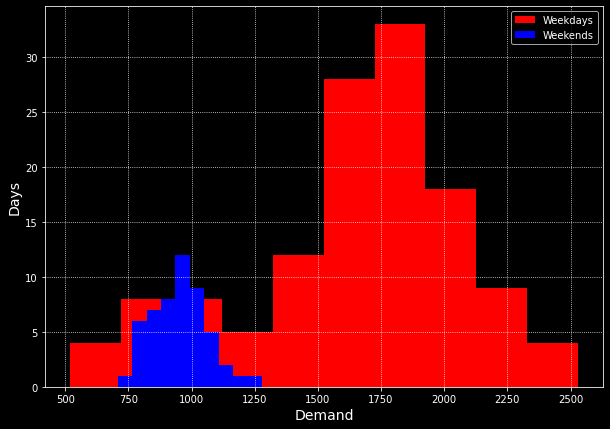

In [8]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,7))
ax.set_ylabel('Days', size=14)
ax.set_xlabel('Demand', size=14)
ax.hist(group_1[group_1.weekdays.isin(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'])].order_id, color='red', label='Weekdays')
ax.hist(group_1[group_1.weekdays.isin(['Thursday','Friday'])].order_id, color='blue', label='Weekends')
ax.grid(linestyle='dotted', linewidth=.8)
ax.legend()
plt.savefig(fname='E:\Work_Space\my_jpeg.jpeg')

The histogram above shows that on weekdays we have obviously more requests than on weekdays. For example, there's been approximately 33 days with 1750 to 2000 daily requests.

----------------

The second step is to use ML algorithms to group the customers based on the RFM (Recency, Frequency, Monetary) method.

In order to have the RFM features, we should first find a base date to caculate the recency of each transactions. So for each userID the last purchase would be their recency.

In [13]:
ls_data['base_date'] = ls_data.date.sort_values().tail(1).values[0]
ls_data['diff'] = (ls_data.base_date - ls_data.date)
ls_data['diff'] = ls_data['diff'].astype(str)
ls_data['diff'] = ls_data['diff'].str.replace(' days', '')
ls_data['diff'] = ls_data['diff'].astype(int)
#-------------------------------------------------------------------------
frequency = ls_data.groupby('user_id').order_id.count().reset_index()
monetary = ls_data.groupby('user_id').total_purchase.sum().reset_index()
recency = ls_data.groupby('user_id')['diff'].min().reset_index()
#-------------------------------------------------------------------------
m1 = pd.merge(frequency, monetary, left_on='user_id', right_on='user_id')
m2 = pd.merge(m1, recency, left_on='user_id', right_on='user_id')
m2.columns = ['user_id', 'Frequency', 'Monetary', 'Recency']

In [15]:
m2.head()

,user_id,Frequency,Monetary,Recency
0,10000,6,822000.0,13
1,10001,3,185000.0,25
2,10002,3,163000.0,3
3,10003,4,1159000.0,29
4,10004,2,338000.0,131


Now the dataframe above is ready to be grouped into different clusters. To do this we deploy KMeans algorithm.

In [17]:
clustered = KMeans(n_clusters=5, random_state=0).fit(m2)
m2['cluster'] = clustered.labels_

In [18]:
m2.groupby('cluster').mean().round(decimals=2).reset_index()

,cluster,user_id,Frequency,Monetary,Recency
0,0,36635.73,3.27,5.137756e+05,44.65
1,1,36428.06,6.46,1.974549e+06,22.17
2,2,57937.00,8.00,1.021250e+08,0.00
3,3,36238.21,8.05,3.083199e+06,17.13
4,4,36672.12,5.11,1.209388e+06,28.31


Different clusters with multiple colouring can be seen down below.

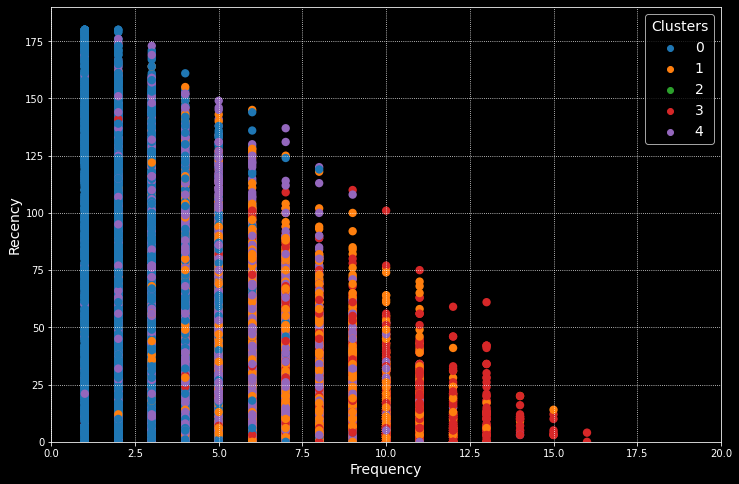

In [20]:
plt.style.use('dark_background')
fig_2, ax_2 = plt.subplots(1,1, figsize=(12, 8))
#ax.scatter(m2.Frequency, m2.Recency, c=m2.cluster, alpha=0.6, cmap='jet');
sns.scatterplot(x=m2.Frequency, y=m2.Recency, hue=m2.cluster, palette='tab10', ax=ax_2, edgecolor='None', s=70);
ax_2.legend(fontsize=14, title_fontsize=14, title='Clusters')
ax_2.set_xlabel('Frequency', size=14)
ax_2.set_ylabel('Recency', size=14)
ax_2.set_xlim(0,20);
ax_2.set_ylim(0,190);
ax_2.grid(linestyle='dotted', linewidth=.8);
fig_2.savefig('asdf.jpg')